# Import libraries and data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python


In [3]:
#import libraries
import pandas as pd
import numpy as np

In [34]:
#get the data
data = pd.read_csv("Daily Bike Sharing.csv", 
                   index_col = "dteday", 
                   parse_dates = True)
data.head(1)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [5]:
#select variables
dataset = data.loc[:, ["cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)                       

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#Data Transformation

In [6]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset.head(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [7]:
#index
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

#Visualization

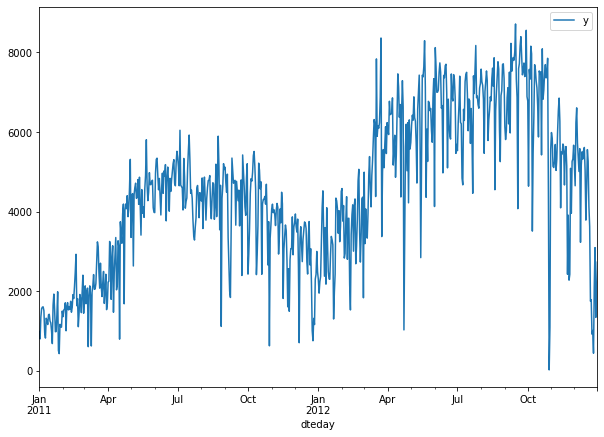

In [8]:
#viz
dataset["y"].plot(figsize = (10, 7), legend = True)

#Training and Test Set

In [9]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-31,2729,0,1,2,0.215833,0.223487,0.5775,0.154846


#Regressors

In [10]:
#get a library
import tensorflow_probability as tfp

In [11]:
#Isolate the regressors
exog = np.asmatrix(dataset.iloc[:,1:].astype(np.float64))
exog[:1]

matrix([[0.      , 0.      , 2.      , 0.344167, 0.363625, 0.805833,
         0.160446]])

In [12]:
#linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

#Seasonality

In [13]:
#isolating dependent variable
y = training_set['y'].astype(np.float64)
y[:5]

dteday
2011-01-01     985.0
2011-01-02     801.0
2011-01-03    1349.0
2011-01-04    1562.0
2011-01-05    1600.0
Freq: D, Name: y, dtype: float64

In [14]:
#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

Instructions for updating:
Do not call `graph_parents`.


In [15]:
#number of days per month
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

In [16]:
#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = num_days_per_month,
                                  observed_time_series = y,
                                  name = "monthly_effect")

#Autoregressive and Trend components

In [17]:
#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

In [18]:
#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

#Tensorflow Structural Time series

In [19]:
#forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

In [20]:
#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [21]:
#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(test_set))

In [22]:
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = test_set.index
predictions_tfp[:2]

dteday
2012-12-01    4216.556140
2012-12-02    3480.177103
Freq: D, Name: TFP, dtype: float64

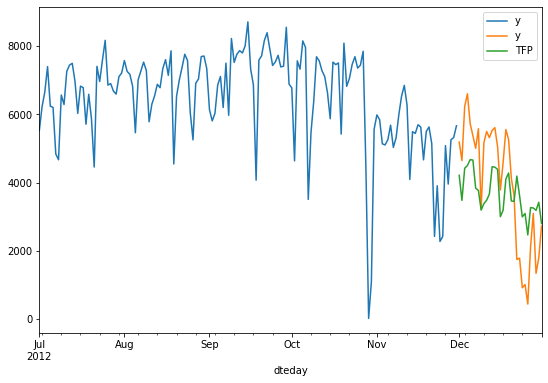

In [23]:
#visualization
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_tfp.plot(legend = True)

#Model assessment

In [24]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(round(mean_absolute_error(test_set['y'], predictions_tfp),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_tfp)), 0))
print(mean_absolute_percentage_error(test_set['y'], predictions_tfp))

1289.0
1446.0
0.6096091977865696


In [25]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_tfp)

60.960919778656965

#export forecasts

In [26]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [27]:
predictions_tfp.to_csv('predictions_tfp.csv', index = True)